In [126]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report


# make parent kaggle folder importable
import sys
import os
sys.path.append(os.path.abspath("../"))
import importlib
import utils as u
import graphs as g
import processing as p
import extraction as e
import selection as s
import model as m
import datasource as ds

# Data

In [79]:
importlib.reload(ds)

train_data = ds.load_train_data()
train_data.info()

Loading train data... *  
Inputing data... *  
Loading words... *  
Loading chars... *  
Loading count... *  
Loading similar... *  
Loading freqs1... *  
Loading freqs2... *  
DONE train data. *  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 12 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
shared_words    404290 non-null float64
shared_chars    404290 non-null float64
count           404290 non-null float64
similar         404290 non-null float64
freqs1          404290 non-null int64
freqs2          404290 non-null int64
dtypes: float64(4), int64(6), object(2)
memory usage: 37.0+ MB


In [99]:
importlib.reload(ds)

test_data = ds.load_test_data()
test_data.info()

Loading test data... *  
Inputing data... *  
Loading shared words... *  
Loading shared chars... *  
Loading count... *  
Loading similar... *  
Loading freqs1... *  
Loading freqs2... *  
DONE test data. *  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 9 columns):
test_id         int64
question1       object
question2       object
shared_words    float64
shared_chars    float64
count           float64
similar         float64
freqs1          int64
freqs2          int64
dtypes: float64(4), int64(3), object(2)
memory usage: 161.1+ MB


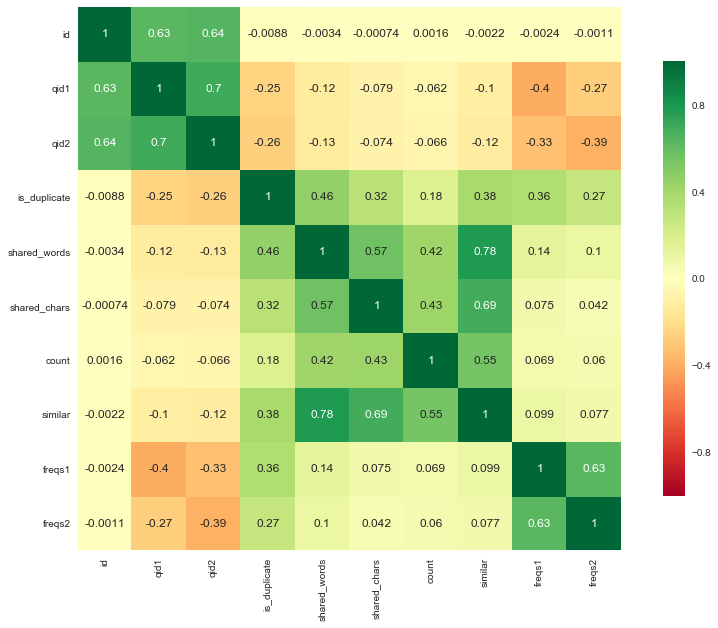

In [88]:
# train_data.describe()
g.plot_correlation_map(train_data)

# Sample extraction

In [ ]:
import itertools

d = train_data[train_data.qid1==8461]
print(q.shape)

ids = list(itertools.combinations(d.qid2, 2))[0]
print(ids)

m = pd.concat([train_data, q], axis=0, ignore_index=True, verify_integrity=True, join='inner')
u.log('t', train_data.shape)
u.log('m', m.shape)

# u.log('cs', len(cs))

# train_data[['qid1']].groupby(['qid1']).size()

# Feature extraction

In [93]:
importlib.reload(ds)

tr, te = ds.load_data()
encoder, features = ds.questions_encoder(tr, te)

Loading train data... *  
Inputing data... *  
Loading test data... *  
Inputing data... *  
corpus * 500 


In [157]:
importlib.reload(ds)

# ds.load_unigrams(train_data)
# ds.load_bigrams(train_data)
# ds.load_trigrams(train_data)
ds.load_stops(train_data)

Loading stops... *  


In [ ]:
# tf-idf score

importlib.reload(e)

x_q1 = e.extract(train_data, 'question1', question_we)
x_q2 = e.extract(train_data, 'question2', question_we)

# x_q1_test = e.extract(test_data, 'question1', question_we)
# x_q2_test = e.extract(test_data, 'question2', question_we)

def tfidf(row):
    tf1 = x_q1.iloc[row.id].sum()
    tf2 = x_q2.iloc[row.id].sum()
    return tf1 + tf2

train_data['tfidf'] = train_data.apply(tfidf, axis=1, raw=True)
# test_data['tfidf'] = x_q1_test.sum(axis=1) + x_q2_test.sum(axis=1)

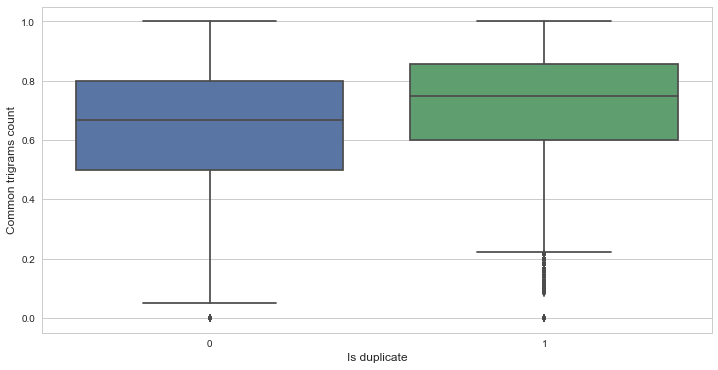

In [158]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="stops_ratio", data=train_data)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common trigrams count', fontsize=12)
plt.show()

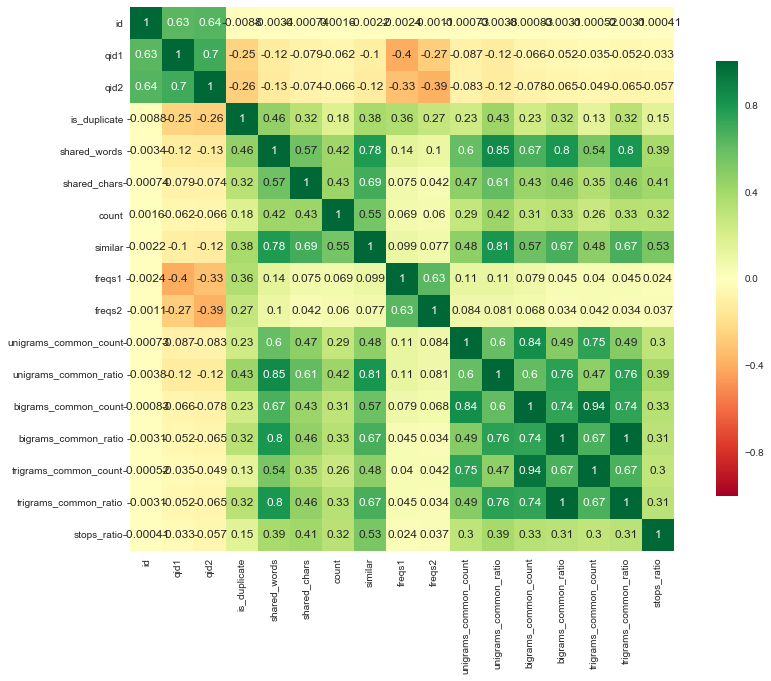

In [159]:
train_data.describe()
g.plot_correlation_map(train_data)

# Feature selection

In [82]:
labels = ['0', '1']

y = train_data.is_duplicate
# print(y.value_counts())
Y = p.onehot(y)

Y: (404290, 2) 


In [160]:
importlib.reload(p)

# pf1 = s.percentile_filter(x_q1, y, percentile=50)
# pf2 = s.percentile_filter(x_q2, y, percentile=50)

x0 = train_data[['shared_words', 'shared_chars', 'similar', 'unigrams_common_ratio', 'bigrams_common_ratio', 'trigrams_common_ratio', 'stops_ratio']]
# x1 = s.select(x_q1, pf1, question_features)
# x2 = s.select(x_q2, pf2, question_features)
x3, scaler = p.scale(train_data[['count', 'freqs1', 'freqs2']])

x = pd.DataFrame(index=train_data.index)
x = pd.merge(x, x0, left_index=True, right_index=True)
# x = pd.merge(x, x1, left_index=True, right_index=True)
# x = pd.merge(x, x2, left_index=True, right_index=True)
x = pd.merge(x, x3, left_index=True, right_index=True)

X = x.values
u.log('X train', X.shape)


x0_test = test_data[['shared_words', 'shared_chars', 'similar']]
# x1_test = s.select(x_q1_test, pf1, question_features)
# x2_test = s.select(x_q2_test, pf2, question_features)
x3_test, scaler = p.scale(test_data[['count', 'freqs1', 'freqs2']])

x_test = pd.DataFrame(index=test_data.index)
x_test = pd.merge(x_test, x0_test, left_index=True, right_index=True)
# x_test = pd.merge(x_test, x1_test, left_index=True, right_index=True)
# x_test = pd.merge(x_test, x2_test, left_index=True, right_index=True)
x_test = pd.merge(x_test, x3_test, left_index=True, right_index=True)

X_test = x_test.values
u.log('X test', X_test.shape)

X train * (404290, 10) 
X test * (2345796, 6) 


In [161]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

u.log('X train', X_train.shape)
u.log('y train', y_train.shape)
Y_train = p.onehot(y_train, title='Y train')

u.log('X val', X_val.shape)
u.log('y val', y_val.shape)
Y_val = p.onehot(y_val, title='Y val')

X train * (303217, 10) 
y train * (303217,) 
Y train * (303217, 2) 
X val * (101073, 10) 
y val * (101073,) 
Y val * (101073, 2) 


# Model

## Keras

In [165]:
importlib.reload(m)
from keras import optimizers as o
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model = m.keras_single_classification(X.shape[1])
model.compile(loss='binary_crossentropy', optimizer=o.RMSprop(lr=1e-3), metrics=['accuracy'], class_weight=cw)
history = model.fit(X_train, y_train, batch_size=10000, epochs=20)

result = model.evaluate(X_val, y_val, verbose=1)
print('')
u.log(model.metrics_names, result)

# plt.figure(figsize=(12,8))
# g.plot_accuracy(history)
# g.plot_loss(history)

/Users/icostan/Work/kaggle/ENV/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/20
303217/303217 [==============================] - 0s - loss: 0.6899 - acc: 0.6495     
Epoch 2/20
303217/303217 [==============================] - 0s - loss: 0.6830 - acc: 0.6866     

# XGB

In [162]:
import xgboost as xgb

xgbc = xgb.XGBClassifier(learning_rate=0.1, n_estimators=50, silent=False)
xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='logloss', verbose=True)

score = xgbc.score(X_val, y_val)

[0]	validation_0-logloss:0.650538	validation_1-logloss:0.650477
[1]	validation_0-logloss:0.613865	validation_1-logloss:0.613682
[2]	validation_0-logloss:0.583293	validation_1-logloss:0.583048
[3]	validation_0-logloss:0.556829	validation_1-logloss:0.556466
[4]	validation_0-logloss:0.535174	validation_1-logloss:0.534789
[5]	validation_0-logloss:0.515685	validation_1-logloss:0.515219
[6]	validation_0-logloss:0.499509	validation_1-logloss:0.499023
[7]	validation_0-logloss:0.484525	validation_1-logloss:0.483962
[8]	validation_0-logloss:0.472321	validation_1-logloss:0.471708
[9]	validation_0-logloss:0.461498	validation_1-logloss:0.460908
[10]	validation_0-logloss:0.451131	validation_1-logloss:0.450467
[11]	validation_0-logloss:0.442757	validation_1-logloss:0.442099
[12]	validation_0-logloss:0.434556	validation_1-logloss:0.433766
[13]	validation_0-logloss:0.427836	validation_1-logloss:0.427028
[14]	validation_0-logloss:0.421194	validation_1-logloss:0.420349
[15]	validation_0-logloss:0.415819	

## Scikit

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

# clf = KNeighborsClassifier()
# clf = SGDClassifier(verbose=1)
# clf = MultinomialNB()

# clf = RandomForestClassifier(n_estimators=10, class_weight='balanced', verbose=1)
# clf = GradientBoostingClassifier(n_estimators=10, random_state=6, verbose=1)
# clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, verbose=1)


clf.fit(X_train, y_train)
score = clf.score(X_val, y_val)
u.log('Score', score)

# Cross validation

Logloss * 0.353058066709 
R *              precision    recall  f1-score   support

          0       0.84      0.91      0.87     63826
          1       0.81      0.70      0.76     37247

avg / total       0.83      0.83      0.83    101073
 
Confusion matrix, without normalization
[[57855  5971]
 [10992 26255]]


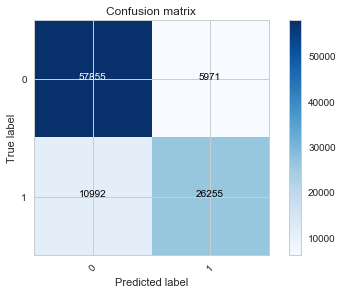

In [111]:
# y_val_prob = model.predict(X_val)
y_val_prob = xgbc.predict_proba(X_val)[:, 1]
# y_val_prob = clf.predict_proba(X_val)

y_val_pred = (y_val_prob > 0.5).astype('int32')

u.log('Logloss', log_loss(y_val, y_val_prob))
u.log('R', classification_report(y_val, y_val_pred, target_names=labels))

cm = confusion_matrix(y_val, y_val_pred)
g.plot_confusion_matrix(cm, labels)

# Prediction

In [112]:
# YY = keras.predict(X_test)
# YY = clf.predict_proba(X_test)
YY = xgbc.predict_proba(X_test)[:, 1]

print(YY.shape)
print(YY[:10])

(2345796,)
[ 0.03080662  0.29134125  0.35970497  0.0233999   0.38340589  0.04134487
  0.67454368  0.28713065  0.46619663  0.04527337]


# Submission

In [115]:
import time

sample = pd.read_csv('input/sample_submission.csv')
print(sample.shape)

submission = pd.DataFrame(columns=['test_id', 'is_duplicate'])
submission.test_id = sample.test_id
submission.is_duplicate = YY
submission.info()

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)

(2345796, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 2 columns):
test_id         int64
is_duplicate    float32
dtypes: float32(1), int64(1)
memory usage: 26.8 MB


# References

* https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
* https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots
* https://www.kaggle.com/jturkewitz/magic-features-0-03-gain
* https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
* https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-quora-ques-pair
* https://www.kaggle.com/woters/xgb-starter-12357/code
* https://www.kaggle.com/alijs1/xgb-starter-12357